In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

# Load the dataset
df = pd.read_csv('heart (2).csv')

# Handle missing values (if any)
df.fillna(df.mean(), inplace=True)

# Normalize numerical features
scaler = MinMaxScaler()
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Encode categorical variables
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Save the cleaned data
df.to_csv('cleaned_data.csv', index=False)

               age     trestbps         chol      thalach      oldpeak  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.000000   
mean      0.529878     0.354827     0.273973     0.596291     0.172910   
std       0.189006     0.165252     0.117791     0.175616     0.189493   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.395833     0.245283     0.194064     0.465649     0.000000   
50%       0.562500     0.339623     0.260274     0.618321     0.129032   
75%       0.666667     0.433962     0.340183     0.725191     0.290323   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            target  
count  1025.000000  
mean      0.513171  
std       0.500070  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max       1.000000  


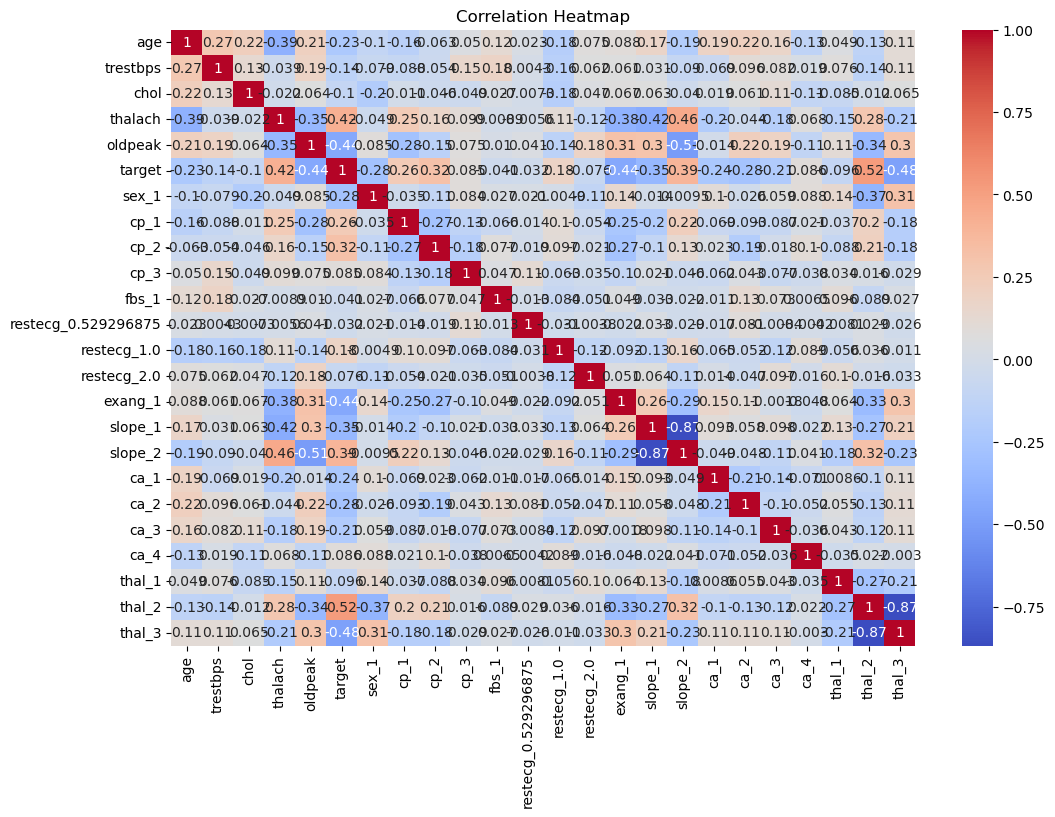

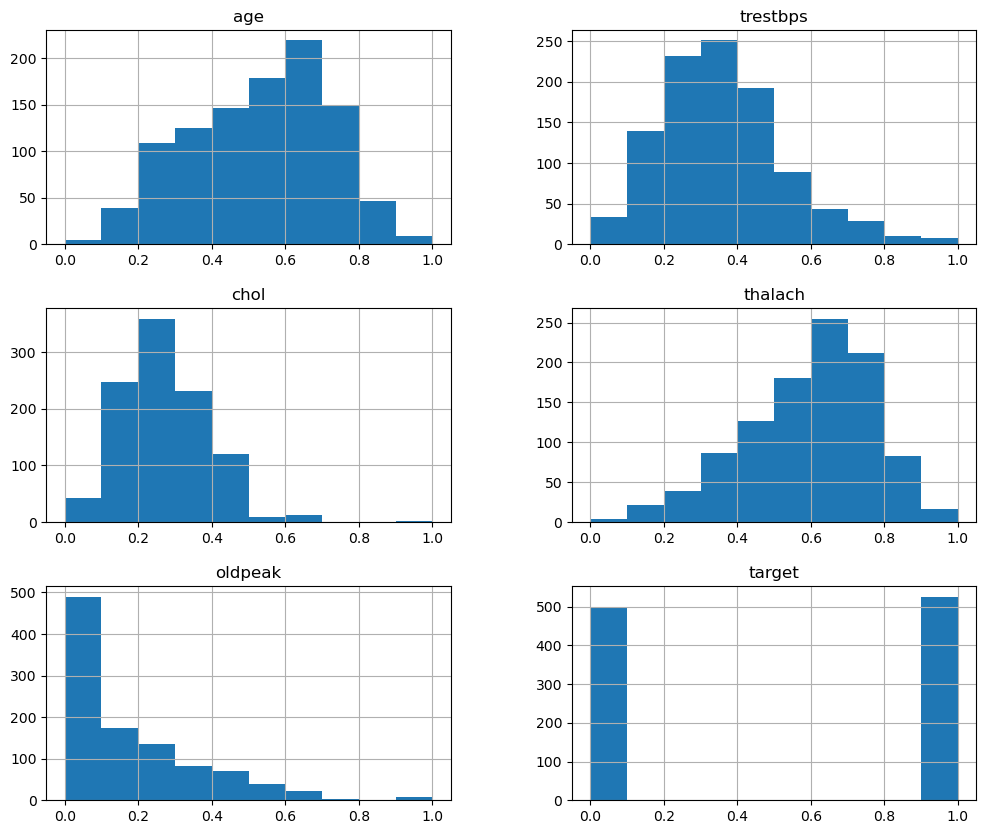

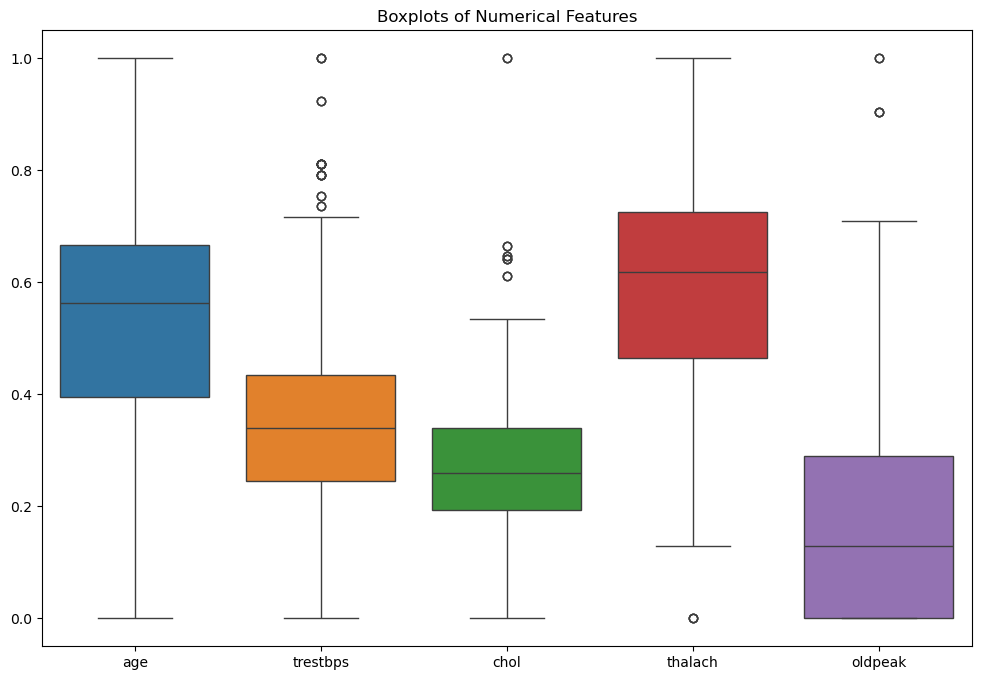

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical summary
print(df.describe())

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Histograms and Boxplots
df.hist(figsize=(12, 10))
plt.show()

# Boxplots for numerical features
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numerical_features])
plt.title('Boxplots of Numerical Features')
plt.show()

In [2]:
from experta import *

class HeartDiseaseRisk(KnowledgeEngine):
    @DefFacts()
    def _initial_facts(self):
        yield Fact(action="assess_risk")

    @Rule(Fact(action="assess_risk"),
          Fact(cholesterol=MATCH.chol),
          Fact(age=MATCH.age),
          TEST(lambda chol, age: chol > 240 and age > 50))
    def high_risk_cholesterol_age(self):
        self.declare(Fact(risk="high"))

    @Rule(Fact(action="assess_risk"),
          Fact(blood_pressure=MATCH.bp),
          Fact(smoking=MATCH.smoke),
          TEST(lambda bp, smoke: bp > 140 and smoke == "Yes"))
    def high_risk_bp_smoking(self):
        self.declare(Fact(risk="high"))

    @Rule(Fact(action="assess_risk"),
          Fact(exercise=MATCH.exercise),
          Fact(bmi=MATCH.bmi),
          TEST(lambda exercise, bmi: exercise == "Regular" and bmi < 25))
    def low_risk_exercise_bmi(self):
        self.declare(Fact(risk="low"))

    @Rule(Fact(action="assess_risk"),
          NOT(Fact(risk=W())))
    def medium_risk(self):
        self.declare(Fact(risk="medium"))

# Example usage
engine = HeartDiseaseRisk()
engine.reset()
engine.declare(Fact(cholesterol=250, age=55, blood_pressure=145, smoking="Yes", exercise="Regular", bmi=24))
engine.run()
print(engine.facts)

<f-0>: InitialFact()
<f-1>: Fact(action='assess_risk')
<f-2>: Fact(cholesterol=250, age=55, blood_pressure=145, smoking='Yes', exercise='Regular', bmi=24)
<f-3>: Fact(risk='high')
<f-4>: Fact(risk='low')


In [7]:
# Split the data
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-Score: {f1_score(y_test, y_pred)}")

# Save the model
joblib.dump(model, 'decision_tree_model.pkl')

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


['decision_tree_model.pkl']

In [9]:
# Evaluate the expert system (this is a simplified example)
# Assume we have a function to convert data to facts and run the expert system
def evaluate_expert_system(data):
    engine = HeartDiseaseRisk()
    engine.reset()
    engine.declare(Fact(cholesterol=data['chol'], age=data['age'], blood_pressure=data['trestbps'], smoking="Yes", exercise="Regular", bmi=24))
    engine.run()
    return engine.facts

# Example comparison (this is a simplified example)
expert_predictions = []
for index, row in X_test.iterrows():
    result = evaluate_expert_system(row)
    expert_predictions.append(1 if 'high' in result else 0)

print(f"Expert System Accuracy: {accuracy_score(y_test, expert_predictions)}")

Expert System Accuracy: 0.4975609756097561
